## 1. Introduction

Purpose and goals for this EDA

Data source

Background information

## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from ftfy import fix_text
from num2words import num2words

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import sklearn

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the data and check the first few lines
# Need to change the file to after processing 

dataset_path = "../Raw Data Files/final_job_posting.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 3. Basic Summary of the data

Display basic information about the dataset:

The number of rows and columns.
Data types of each column.
Summary statistics (mean, median, min, max and more)

In [3]:
print(dataset.shape)
dataset.info()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [4]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<Axes: >

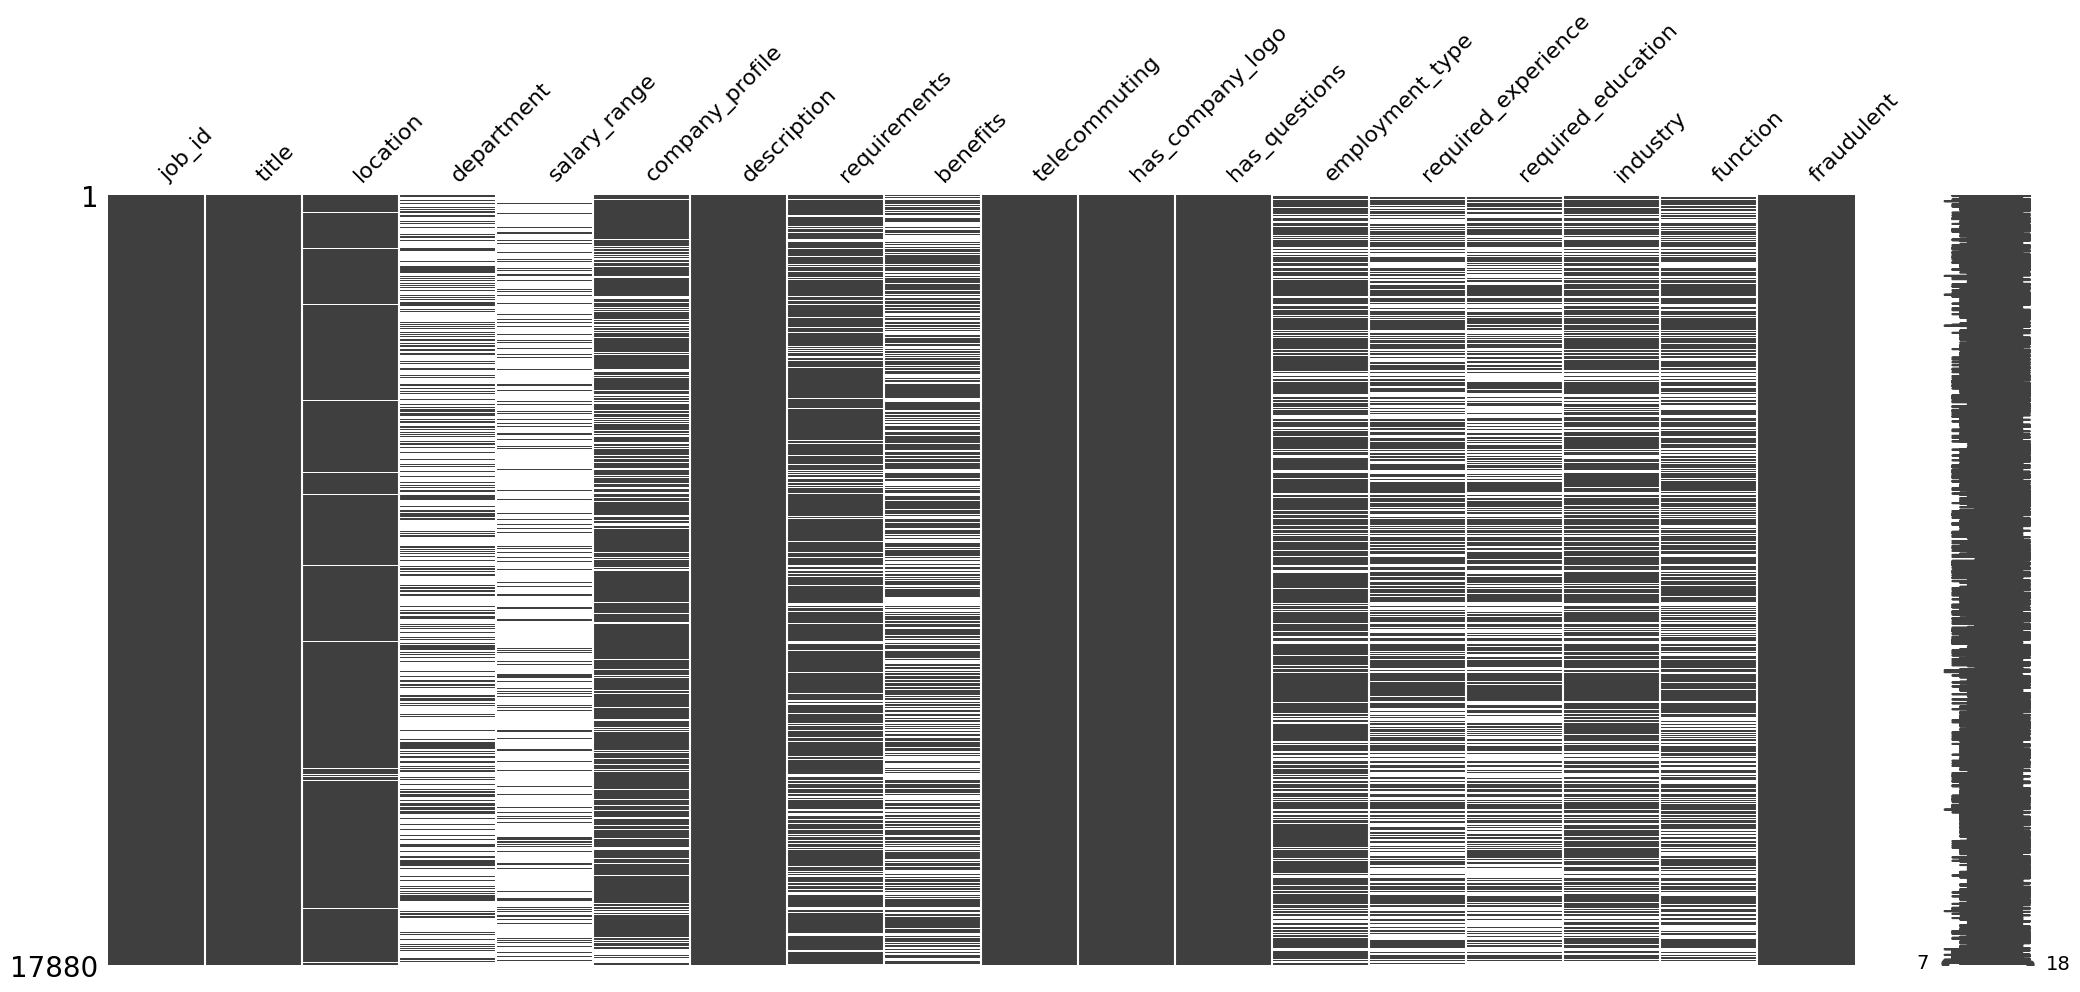

In [5]:
# Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

In [6]:
dataset.duplicated().sum()

0

From the data, we understand that there are 0 duplicated rows and there are a lot of data columns that has a lot of NA values especially department and salary range. This is followed by required_education, benefits and required_experience. We will dive deep to understand each data columns better to make a decision if we want to drop the column or not.

In [7]:
dataset.location.value_counts().head(10)

location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
US, TX, Houston          269
US, IL, Chicago          255
US, DC, Washington       251
DE, BE, Berlin           221
NZ, N, Auckland          218
Name: count, dtype: int64

In [8]:
dataset.company_profile.head(10)

0    We're Food52, and we've created a groundbreaki...
1    90 Seconds, the worlds Cloud Video Production ...
2    Valor Services provides Workforce Solutions th...
3    Our passion for improving quality of life thro...
4    SpotSource Solutions LLC is a Global Human Cap...
5                                                  NaN
6    Founded in 2009, the Fonpit AG rose with its i...
7    Airenvy’s mission is to provide lucrative yet ...
8    Solutions3 is a woman-owned small business who...
9    Novitex Enterprise Solutions, formerly Pitney ...
Name: company_profile, dtype: object

In [9]:
dataset.description.head(10)

0    Food52, a fast-growing, James Beard Award-winn...
1    Organised - Focused - Vibrant - Awesome!Do you...
2    Our client, located in Houston, is actively se...
3    THE COMPANY: ESRI – Environmental Systems Rese...
4    JOB TITLE: Itemization Review ManagerLOCATION:...
5    Job OverviewApex is an environmental consultin...
6    Your Responsibilities: Manage the English-spea...
7    Who is Airenvy?Hey there! We are seasoned entr...
8    Implementation/Configuration/Testing/Training ...
9    The Customer Service Associate will be based i...
Name: description, dtype: object

In [10]:
dataset.requirements.head(10)

0    Experience with content management systems a m...
1    What we expect from you:Your key responsibilit...
2    Implement pre-commissioning and commissioning ...
3    EDUCATION: Bachelor’s or Master’s in GIS, busi...
4    QUALIFICATIONS:RN license in the State of Texa...
5                                                  NaN
6    Your Know-How:                                ...
7    Experience with CRM software, live chat, and p...
8    MUST BE A US CITIZEN.An active TS/SCI clearanc...
9    Minimum Requirements:Minimum of 6 months custo...
Name: requirements, dtype: object

In [11]:
dataset.benefits.head(10)

0                                                  NaN
1    What you will get from usThrough being part of...
2                                                  NaN
3    Our culture is anything but corporate—we have ...
4                                Full Benefits Offered
5                                                  NaN
6    Your Benefits: Being part of a fast-growing co...
7    Competitive Pay. You'll be able to eat steak e...
8                                                  NaN
9                                                  NaN
Name: benefits, dtype: object

In [12]:
dataset.title.str.strip().value_counts().head(10)

title
English Teacher Abroad                                406
Customer Service Associate                            198
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate - Part Time                 91
Software Engineer                                      90
English Teacher Abroad (Conversational)                83
Account Manager                                        81
Project Manager                                        71
Web Developer                                          69
Customer Service Representative                        63
Name: count, dtype: int64

In [13]:
dataset.industry.value_counts(dropna=False).head(10)

industry
NaN                                    4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Name: count, dtype: int64

In [14]:
dataset.department.value_counts(dropna=False).head(10)

department
NaN                       11547
Sales                       551
Engineering                 487
Marketing                   401
Operations                  270
IT                          225
Development                 146
Product                     112
Information Technology       86
Design                       76
Name: count, dtype: int64

In [15]:
dataset.function.value_counts(dropna=False).head(10)

function
NaN                       6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Name: count, dtype: int64

In [16]:
dataset.salary_range.value_counts(dropna=False).head(10)

salary_range
NaN             15012
0-0               142
40000-50000        66
30000-40000        55
45000-67000        37
25000-30000        37
30000-50000        32
80000-100000       30
70000-90000        30
35000-45000        30
Name: count, dtype: int64

In [17]:
dataset.telecommuting.value_counts()

telecommuting
0    17113
1      767
Name: count, dtype: int64

In [18]:
dataset.has_company_logo.value_counts()

has_company_logo
1    14220
0     3660
Name: count, dtype: int64

In [19]:
dataset.has_questions.value_counts()

has_questions
0    9088
1    8792
Name: count, dtype: int64

In [20]:
dataset.employment_type.value_counts(dropna=False)

employment_type
Full-time    11620
NaN           3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

In [21]:
dataset.required_experience.value_counts(dropna=False)

required_experience
NaN                 7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: count, dtype: int64

In [22]:
dataset.required_education.value_counts(dropna=False)

required_education
NaN                                  8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: count, dtype: int64

In [26]:
# salary_group
dataset.salary_group.value_counts(dropna=False).head(5)

salary_group
NaN              15038
slightly low      1482
low                644
extremely low      346
slightly high      319
Name: count, dtype: int64

## 4. Univariate Analysis 

Analyze individual features (columns) in isolation.

Numerical features:
    Create histograms, box plots, and density plots.
    Calculate summary statistics and more
    
Categorical features:
    Generate bar plots (count plots) to visualize category distribution.
    Display the number of unique categories and more

Identify outliers and anomalies.

In [43]:
dataset.isna().sum()

title                       0
department                  0
salary_range            15012
telecommuting               0
has_company_logo            0
has_questions               0
employment_type          3471
required_experience      7050
required_education       8105
industry                    0
function                    0
fraudulent                  0
salary_start                0
salary_end                  0
salary_interval             0
salary_group            15038
location_country            0
title_contain_urgent        0
have_company_profile        0
have_description            0
have_requirements           0
have_benefits               0
full_text                   0
high_salary                 0
category                    0
cat_flesch_score            0
cat_fk_grade_level          0
dtype: int64

In [44]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)

telecommuting           4.105923e-02
has_company_logo        1.628058e-01
has_questions           2.499455e-01
fraudulent              4.609073e-02
salary_start            4.977911e+13
salary_end              1.163792e+14
salary_interval         1.402458e+13
title_contain_urgent    3.066772e-03
have_company_profile    1.507905e-01
have_description        5.592841e-05
have_requirements       1.280546e-01
have_benefits           2.406733e-01
cat_flesch_score        3.270825e+03
cat_fk_grade_level      6.109801e+01
dtype: float64


In [50]:
dataset.describe()

,telecommuting,has_company_logo,has_questions,fraudulent,salary_start,salary_end,salary_interval,title_contain_urgent,have_company_profile,have_requirements,have_benefits,cat_flesch_score,cat_fk_grade_level,text_len
count,17880.000000,17880.000000,17880.000000,17880.000000,1.788000e+04,1.788000e+04,1.788000e+04,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434,8.192367e+04,1.291139e+05,4.719019e+04,0.003076,0.814989,0.849217,0.596644,-44.241667,20.352310,253.399609
std,0.202631,0.403492,0.499945,0.214688,7.055431e+06,1.078792e+07,3.744941e+06,0.055378,0.388317,0.357847,0.490585,57.191124,7.816522,139.348833
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-345.100000,-3.100000,2.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,0.000000,-85.890000,14.700000,150.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,1.000000,-49.000000,20.600000,239.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000,1.000000,-1.290000,26.500000,331.000000
max,1.000000,1.000000,1.000000,1.000000,8.000000e+08,1.200000e+09,4.000000e+08,1.000000,1.000000,1.000000,1.000000,120.210000,61.900000,1516.000000


### Relationship between Features and Classification Target

In [51]:
# title
dataset[dataset['fraudulent']==1]['title'].value_counts().head(10)

title
data entry admin clerical positions work from home                                 21
home based payroll typist data entry clerks positions available                    21
administrative assistant                                                           21
cruise staff wanted urgent                                                         21
customer service representative                                                    19
home based payroll data entry clerk position earn one hundred two hundred daily    12
payroll clerk                                                                      11
data entry                                                                         11
account sales managers eighty one hundred and thirty zero yr                       10
payroll data coordinator positions earn one hundred two hundred daily              10
Name: count, dtype: int64

In [52]:
dataset[dataset['fraudulent']==0]['title'].value_counts().head(5)

title
english teacher abroad                             406
customer service associate                         198
graduates english teacher abroad conversational    144
customer service associate part time                97
software engineer                                   92
Name: count, dtype: int64

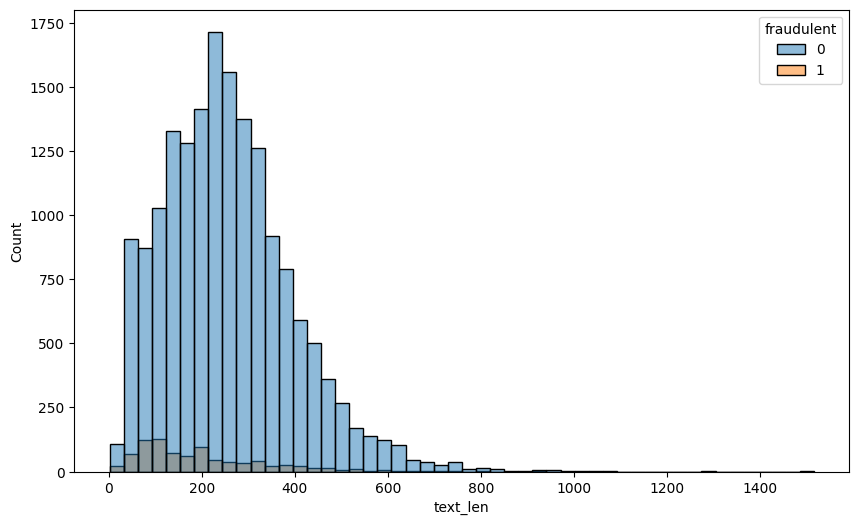

In [53]:
# text_len
plt.figure(figsize=(10,6))
sns.histplot(data=dataset, x="text_len", hue="fraudulent", kde=False, bins=50)
plt.show()

In [54]:
dataset['text_len'].describe()

count    17880.000000
mean       253.399609
std        139.348833
min          2.000000
25%        150.000000
50%        239.000000
75%        331.000000
max       1516.000000
Name: text_len, dtype: float64

In [55]:
dataset[dataset['fraudulent']==0]['text_len'].describe()

count    17014.000000
mean       256.226343
std        138.634494
min          7.000000
25%        154.000000
50%        242.000000
75%        333.000000
max       1516.000000
Name: text_len, dtype: float64

In [56]:
dataset[dataset['fraudulent']==1]['text_len'].describe()

count    866.000000
mean     197.863741
std      141.778627
min        2.000000
25%       92.250000
50%      161.500000
75%      268.750000
max      915.000000
Name: text_len, dtype: float64

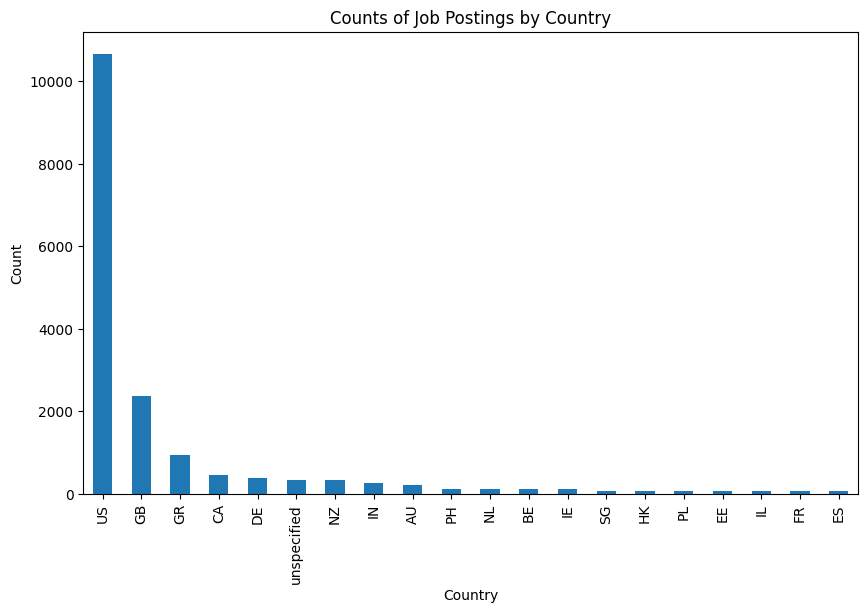

In [106]:
all_ctry = dataset['location_country'].value_counts(dropna=False)

top_20 = dataset['location_country'].value_counts(dropna=False).head(20)

plt.figure(figsize=(10, 6))
top_20.plot(kind='bar')
plt.title('Counts of Job Postings by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [57]:
# full_text
fraud_text = dataset[dataset.fraudulent == 1].full_text
nonfraud_text = dataset[dataset.fraudulent == 0].full_text

In [ ]:
# full_text
fraud_cat = dataset[dataset.fraudulent == 1].category
nonfraud_cat = dataset[dataset.fraudulent == 0].category

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

In [ ]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_cat)))
plt.imshow(wc,interpolation = 'bilinear')

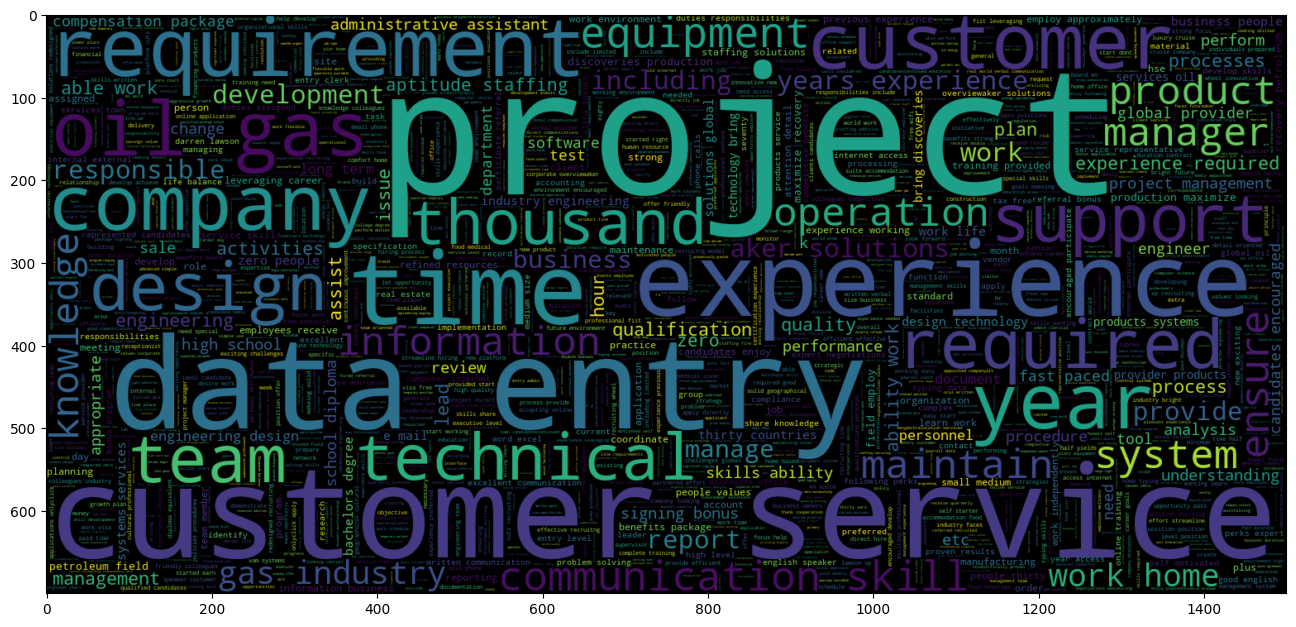

In [58]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_text)))
plt.imshow(wc,interpolation = 'bilinear')

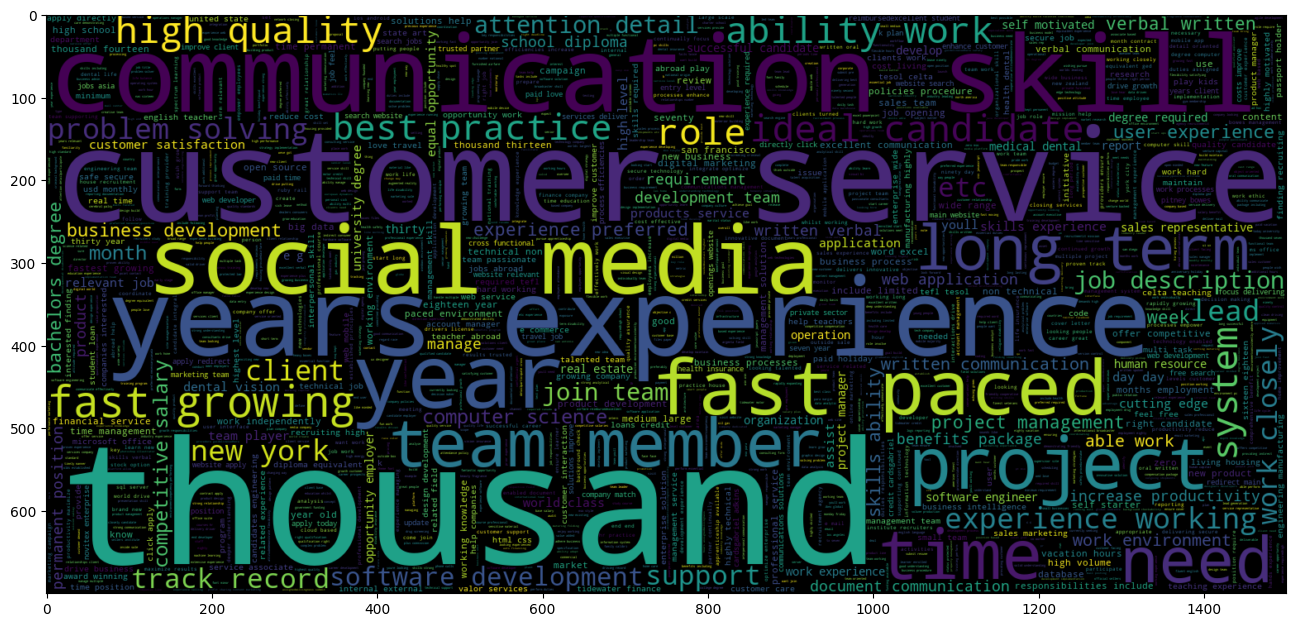

In [59]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_text)))
plt.imshow(wc,interpolation = 'bilinear')

<Axes: xlabel='have_company_profile'>

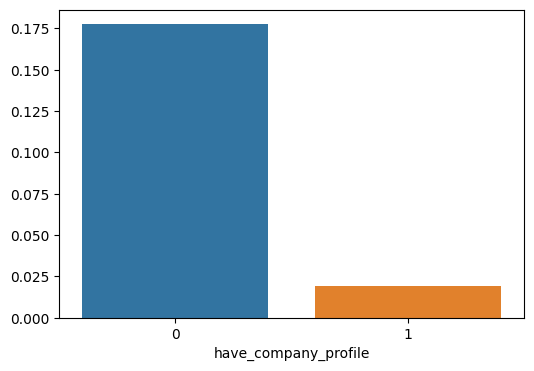

In [60]:
# have_company_profile
data = dataset.groupby('have_company_profile')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=data.index, y=data.values, ax=ax)

<Axes: xlabel='have_requirements'>

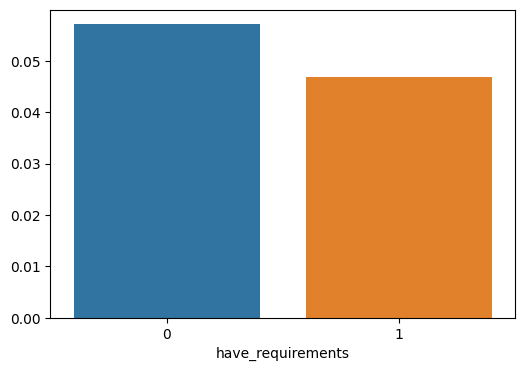

In [61]:
# have_requirements
data = dataset.groupby('have_requirements')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=data.index, y=data.values, ax=ax)

<Axes: xlabel='have_benefits'>

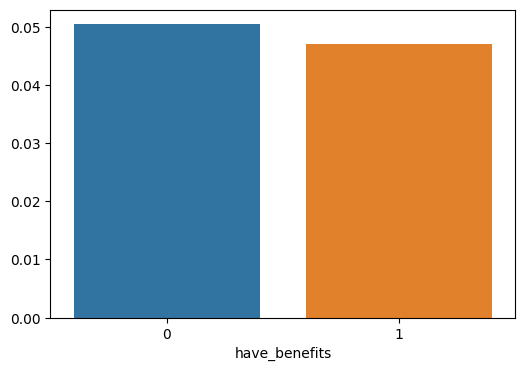

In [62]:
# have_benefits
data = dataset.groupby('have_benefits')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=data.index, y=data.values, ax=ax)

In [63]:
# salary_range
dataset[dataset['fraudulent']==1]['salary_range'].value_counts().head(5)

salary_range
7200-1380000     10
30000-50000       8
250000-500000     7
28000-32000       6
35000-40000       6
Name: count, dtype: int64

In [64]:
dataset[dataset['fraudulent']==0]['salary_range'].value_counts().head(5)

salary_range
0-0            138
40000-50000     65
30000-40000     51
45000-67000     37
25000-30000     32
Name: count, dtype: int64

In [65]:
# salary_group
dataset.groupby('salary_group')['fraudulent'].mean()

salary_group
extremely high    0.052632
extremely low     0.078035
high              0.312500
low               0.090062
slightly high     0.053292
slightly low      0.073549
Name: fraudulent, dtype: float64

In [66]:
dataset[dataset['fraudulent']==1]['salary_group'].value_counts()

salary_group
slightly low      109
low                58
extremely low      27
slightly high      17
high               10
extremely high      1
Name: count, dtype: int64

In [67]:
dataset[dataset['fraudulent']==0]['salary_group'].value_counts()

salary_group
slightly low      1373
low                586
extremely low      319
slightly high      302
high                22
extremely high      18
Name: count, dtype: int64

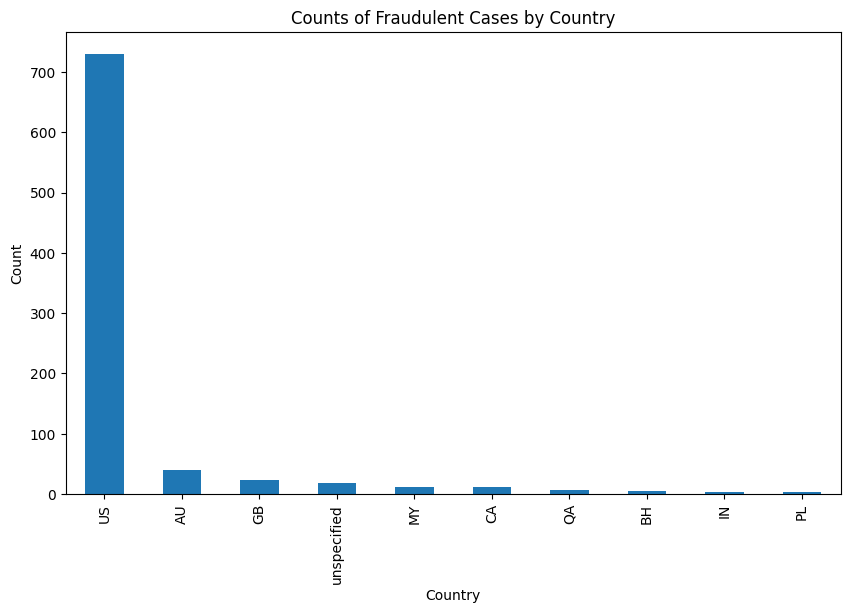

In [68]:
# location
fraudulent_ctry = dataset[dataset['fraudulent'] == 1]['location_country'].value_counts()
fraudulent_ctry_10 = fraudulent_ctry.head(10)
plt.figure(figsize=(10, 6))
fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

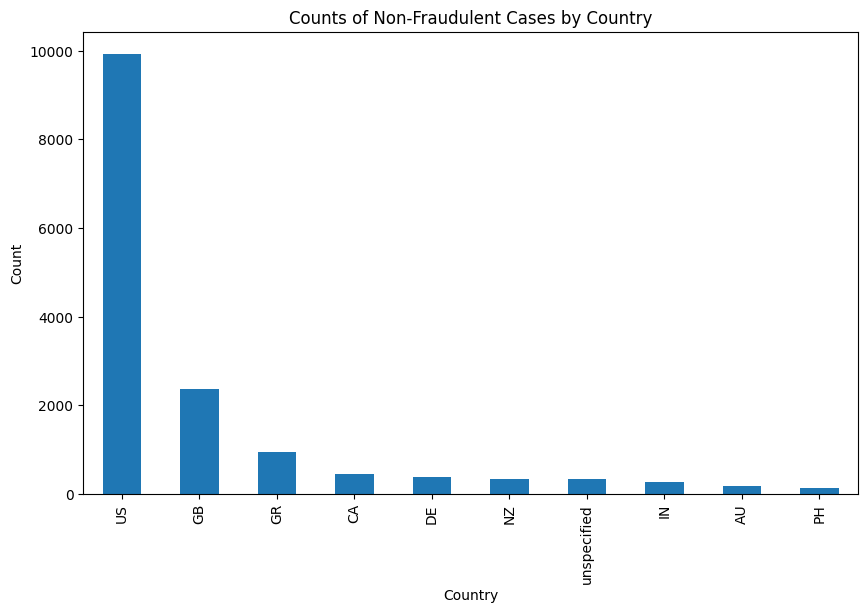

In [69]:
non_fraudulent_ctry = dataset[dataset['fraudulent'] == 0]['location_country'].value_counts()
non_fraudulent_ctry_10 = non_fraudulent_ctry.head(10)
plt.figure(figsize=(10, 6))
non_fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Non-Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='telecommuting'>

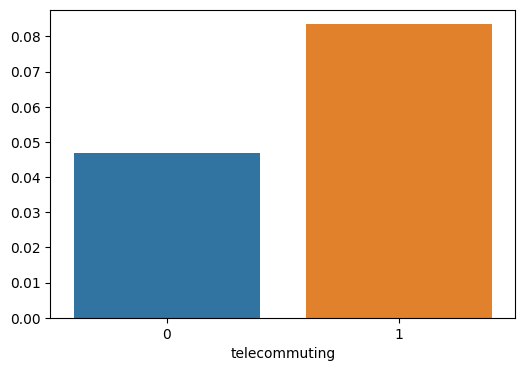

In [75]:
# telecommuting
telecommuting_fraud = dataset.groupby('telecommuting')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=telecommuting_fraud.index, y=telecommuting_fraud.values, ax=ax)

<Axes: xlabel='telecommuting', ylabel='count'>

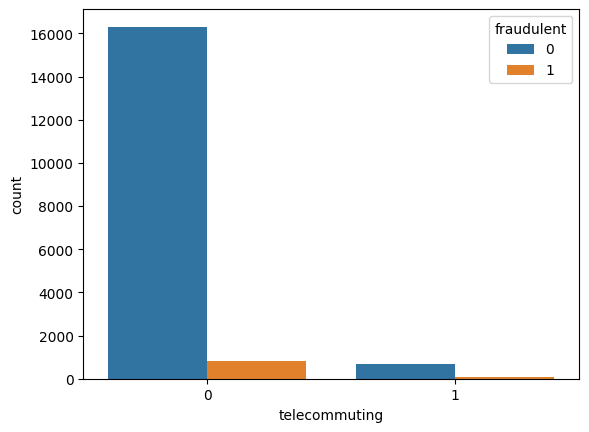

In [76]:
sns.countplot(x='telecommuting',data=dataset,hue='fraudulent')

<Axes: xlabel='has_company_logo'>

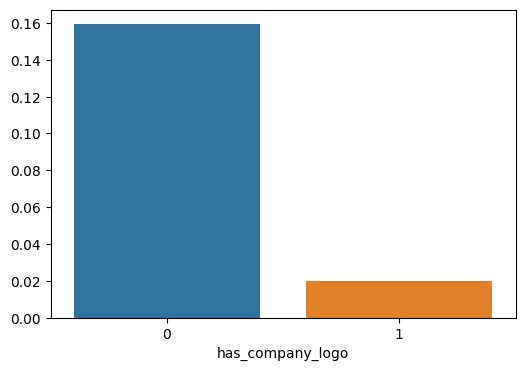

In [77]:
# has_company_logo
has_company_logo_fraud = dataset.groupby('has_company_logo')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_company_logo_fraud.index, y=has_company_logo_fraud.values, ax=ax)

<Axes: xlabel='has_company_logo', ylabel='count'>

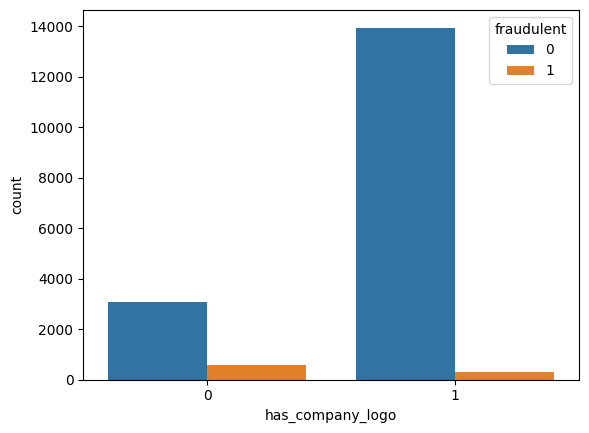

In [78]:
sns.countplot(x='has_company_logo',data=dataset,hue='fraudulent')

<Axes: xlabel='has_questions'>

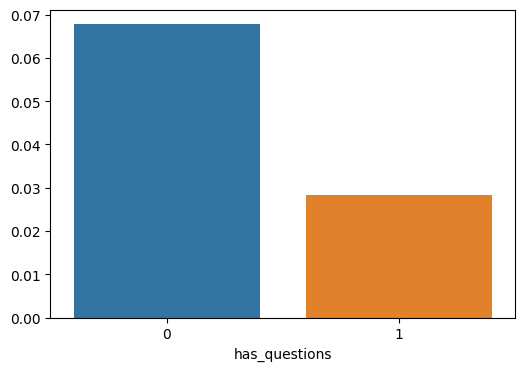

In [79]:
# has_questions
has_questions_fraud = dataset.groupby('has_questions')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_questions_fraud.index, y=has_questions_fraud.values, ax=ax)

<Axes: xlabel='has_questions', ylabel='count'>

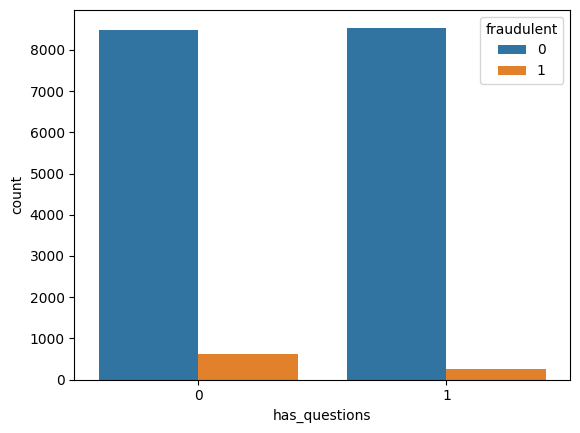

In [80]:
sns.countplot(x='has_questions',data=dataset,hue='fraudulent')

<Axes: xlabel='employment_type'>

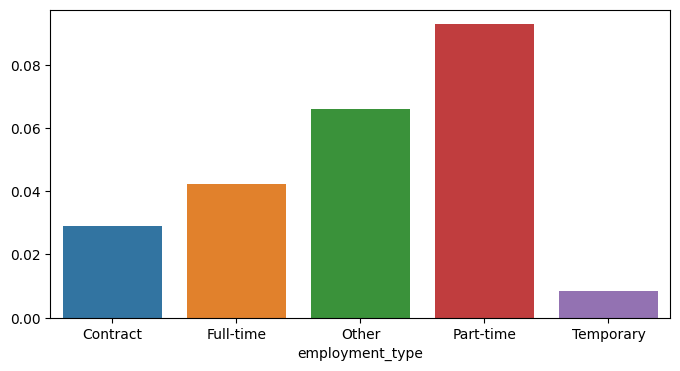

In [81]:
# employment_type
employment_type_fraud = dataset.groupby('employment_type')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.barplot(x=employment_type_fraud.index, y=employment_type_fraud.values, ax=ax)

<Axes: xlabel='employment_type', ylabel='count'>

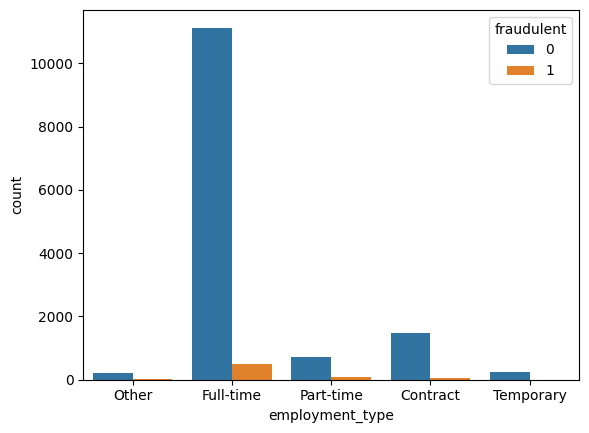

In [82]:
sns.countplot(x='employment_type',data=dataset,hue='fraudulent')

<Axes: xlabel='required_experience'>

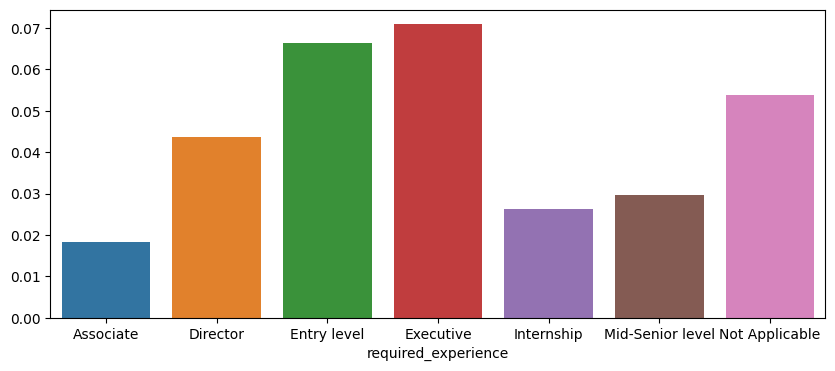

In [83]:
# required_experience
required_experience_fraud = dataset.groupby('required_experience')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.barplot(x=required_experience_fraud.index, y=required_experience_fraud.values, ax=ax)

<Axes: xlabel='required_experience', ylabel='count'>

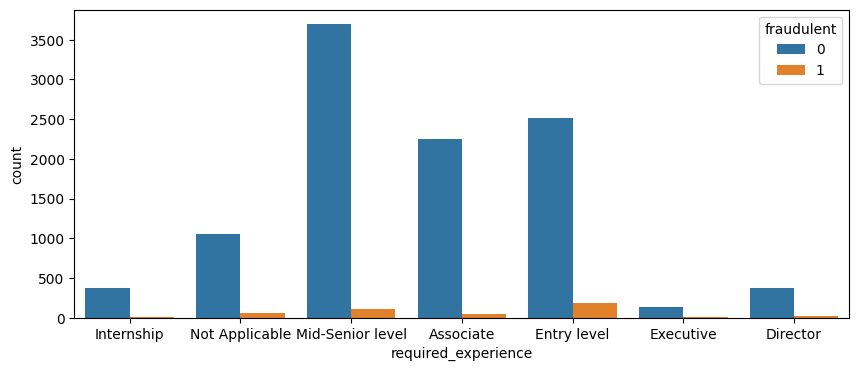

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.countplot(x='required_experience',data=dataset,hue='fraudulent',ax=ax)

In [85]:
# required_education
dataset[dataset['fraudulent']==1]['required_education'].value_counts()

required_education
High School or equivalent            170
Bachelor's Degree                    100
Unspecified                           61
Master's Degree                       31
Some High School Coursework           20
Certification                         19
Associate Degree                       6
Professional                           4
Some College Coursework Completed      3
Doctorate                              1
Name: count, dtype: int64

In [86]:
dataset[dataset['fraudulent']==0]['required_education'].value_counts()

required_education
Bachelor's Degree                    5045
High School or equivalent            1910
Unspecified                          1336
Master's Degree                       385
Associate Degree                      268
Certification                         151
Some College Coursework Completed      99
Professional                           70
Vocational                             49
Doctorate                              25
Vocational - HS Diploma                 9
Some High School Coursework             7
Vocational - Degree                     6
Name: count, dtype: int64

In [87]:
# industry
dataset[dataset['fraudulent']==1]['industry'].value_counts().head(5)

industry
unspecified                  216
oil energy                   109
accounting                    57
hospital health care          51
marketing and advertising     51
Name: count, dtype: int64

In [88]:
dataset[dataset['fraudulent']==0]['industry'].value_counts().head(5)

industry
information technology and services    2521
unspecified                            2402
computer software                      1908
internet                               1237
marketing and advertising              1116
Name: count, dtype: int64

In [89]:
# department
dataset[dataset['fraudulent']==1]['department'].value_counts().head(5)

department
unspecified         383
engineering         112
sales                65
customer service     53
oil energy           28
Name: count, dtype: int64

In [90]:
dataset[dataset['fraudulent']==0]['department'].value_counts().head(5)

department
unspecified         5784
engineering         3153
sales               1752
customer service     922
marketing            854
Name: count, dtype: int64

In [91]:
# function
dataset[dataset['fraudulent']==1]['function'].value_counts().head(5)

function
unspecified         276
engineering         128
administrative      119
customer service     83
sales                53
Name: count, dtype: int64

In [92]:
dataset[dataset['fraudulent']==0]['function'].value_counts().head(5)

function
unspecified               3631
information technology    2444
sales                     1929
engineering               1862
customer service          1381
Name: count, dtype: int64

## 5. Bivariate Analysis

Analyze relationships between pairs of variables.

Numerical features:
    Create scatter plots or pair plots to visualize correlations.
    Compute correlation coefficients (e.g., Pearson, Spearman).

Categorical features:
    Create cross-tabulations or stacked bar plots.

Investigate relationships between numerical and categorical variables. 

Correlation Analysis

## 6. Multivariate Analysis

Explore relationships among more than two variables.
    
Use techniques like heatmap, 3D scatter plots, or parallel coordinates plots.
    
Identify patterns or clusters in the data.

## 7. Text Analysis (?)